<a href="https://colab.research.google.com/github/shivendrra/SmallLanguageModel-project/blob/main/Final%20Models/Transformer/TransformerWIthTiktoken.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data for training the BPE
with open('/content/drive/MyDrive/new_training_data.txt', 'r', encoding='utf-8') as file:
  captions = file.read()

print(len(captions)/1e6, 'million words')

219.382798 million words


In [ ]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.0 MB/s eta 0:00:00


In [ ]:
import timeit
start_time = timeit.default_timer()

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("p50k_base")
tokenizer = tiktoken.encoding_for_model("text-davinci-003")

input_data = tokenizer.encode(captions)
end_time = timeit.default_timer()
total_time = (end_time - start_time) / 60

print("total tokens", len(input_data)/1e6, 'million')
print(f"time taken to train the tokenizer {total_time}mins")

total tokens 47.994108 million
time taken to train the tokenizer 0.7022969253666669mins


In [ ]:
n = int(0.9*len(input_data)) # first 90% will be train, rest val
train_data = input_data[:n]
val_data = input_data[n:]
print(f"train data {len(train_data) / 1e6} million'\n'validation data {len(val_data) / 1e6} million")

train data 43.194697 million'
'validation data 4.799411 million


In [ ]:
# Trimming data for a multiple of 4
# train_remainder = len(train_data) % 4
# val_remainder = len(val_data) % 4
# train_data = train_data[:-train_remainder] if train_remainder != 0 else train_data
# val_data = val_data[:-val_remainder] if val_remainder != 0 else val_data

# print(len(train_data), len(val_data))

18692412 2076932


In [ ]:
import torch

# Convert to tensors
train_data = torch.tensor(train_data, dtype=torch.long)
val_data = torch.tensor(val_data, dtype=torch.long)

print(f"train data = {train_data[:10]}, \nval data = {val_data[:10]}")

train data = tensor([ 5195,   547,   262, 13666,   319,  1468,   640,    88,   198,    65]), 
val data = tensor([   13, 11361,   286, 23748,    13,  9078,    11,  1623,  1122,    11])


In [ ]:
vocab_size = tokenizer.n_vocab
print(vocab_size)

50281


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 32 # independent sequences process in parallel
block_size = 128 # maximum context length for predictions
max_iters = 5000
eval_interval = 100
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 8
n_layer = 8
dropout = 0.2
norm_eps = 1e-05
# ------------

torch.manual_seed(1400)

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd, eps=norm_eps)
        self.ln2 = nn.LayerNorm(n_embd, eps=norm_eps)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd, eps=norm_eps) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias.data)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = GPTLanguageModel()
checkpoint_path = '/content/drive/MyDrive/52.9_transformer_model.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)
m = model.to(device)

# print the number of parameters in the model
n_param = sum(p.numel() for p in m.parameters())/1e6
print(n_param, 'million')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
steps = []
train_losses = []
val_losses = []

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # Store step and loss values for visualization
        steps.append(iter)
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

52.902505 million
step 0: train loss 5.2925, val loss 5.2780
step 100: train loss 5.1310, val loss 4.9329
step 200: train loss 5.0658, val loss 4.8052
step 300: train loss 5.0129, val loss 4.7458
step 400: train loss 4.9957, val loss 4.6957
step 500: train loss 4.9448, val loss 4.6594
step 600: train loss 4.9200, val loss 4.6308
step 700: train loss 4.8983, val loss 4.6060
step 800: train loss 4.8582, val loss 4.5643
step 900: train loss 4.8539, val loss 4.5691
step 1000: train loss 4.8376, val loss 4.5232
step 1100: train loss 4.8215, val loss 4.5027
step 1200: train loss 4.8017, val loss 4.4783
step 1300: train loss 4.7649, val loss 4.4671
step 1400: train loss 4.7626, val loss 4.4521
step 1500: train loss 4.7515, val loss 4.4271
step 1600: train loss 4.7322, val loss 4.4010
step 1700: train loss 4.7119, val loss 4.4046
step 1800: train loss 4.7023, val loss 4.3749
step 1900: train loss 4.6986, val loss 4.3732
step 2000: train loss 4.6837, val loss 4.3539
step 2100: train loss 4.6763

In [ ]:
# save the trained model
torch.save(model.state_dict(), f"{n_param:.1f}_model.pth")

In [ ]:
torch.save(model, f"{n_param:.0f}million_model.pth")

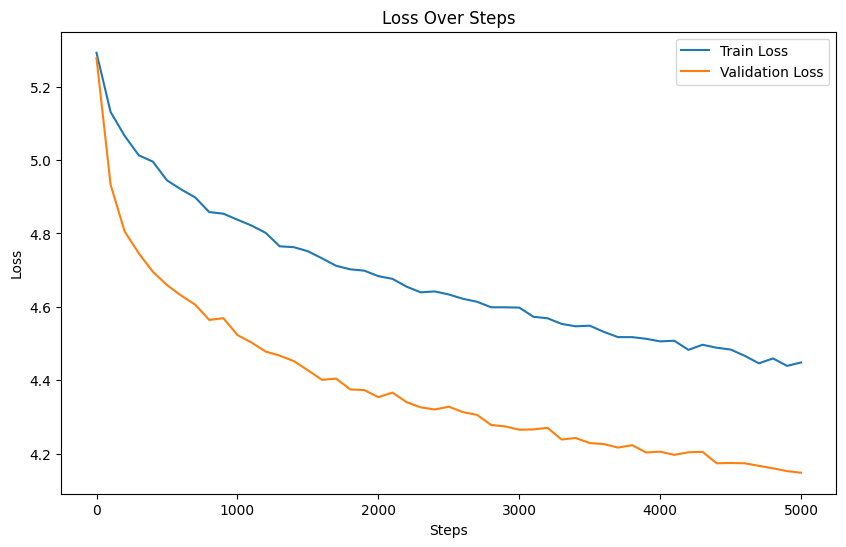

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses, label='Train Loss')
plt.plot(steps, val_losses, label='Validation Loss')
plt.title('Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
target_text = "Would you like to tell me your name because "
context = torch.tensor([tokenizer.encode(target_text)], dtype=torch.long, device=device)
generated_output = tokenizer.decode(m.generate(context, max_new_tokens=10)[0].tolist())
print(generated_output)

Would you like to tell me your name because iphone is used to apologize for your child but
